# Deep Learning avec PyTorch

# Fine tunning de différent CNN pour une tâche de classification

Nous allons comparer les différents modèles de classification pré-entraînés de pytorch. Nous utiliserons le corpus Caltech101. Ce jeu de données contient environ 10000 images 300 x 200 pixels d’objets rangés dans 101 catégories. 

## Les modèles implémentés

AlexNet :

Il se compose de 5 couches de convolution (filtre de taille 11x11 avec un stride (4,4) puis filtre 5x5 avec un stride (1,1) puis trois filtres 3x3 avec un stride (1,1), les paddings (2,2) puis (1,1) sont utilisés), suivies de couches de pooling (max pooling), et de 3 couches entièrement connectées. Il utilise la fonction d'activation ReLU et la technique de dropout pour la régularisation.

VGG16 :

Il se compose de 13 couches de convolution (filtre de taille 3x3, stride (1,1) et padding (1,1)), suivies de couches de pooling (max pooling), et de 3 couches entièrement connectées. Il utilise la fonction d'activation ReLU et la technique de dropout pour la régularisation.

ResNet18 :

ResNet18 fait partie de la famille des Réseaux Résiduels (ResNet). Ils utilisent des blocs résiduels qui permettent de résoudre le problème du "vanishing gradient". Pour cela, les blocs résiduels ont des sauts de connexion qui ajoutent l'entrée originale à la sortie obtenue. Il y a une addition entre l'entrée initiale et la sortie de la dernière couche de convolution du bloc résiduel. ResNet18 commence par une convolution suivie d'un max pooling. Ensuite, il est composé de 4 couches composées de 2 blocs résiduels. Chaque bloc résiduel est composé de deux couches de convolution, suivies d'une couche de normalisation (Batch Normalization) et d'une fonction d'activation ReLU (les entrées des blocs résiduels sont ajoutées à la sortie).

DenseNet161 :

DenseNet est une architecture qui utilise une connectivité dense entre les couches. Chaque couche est connectée à toutes les couches précédentes dans un bloc dense. DenseNet161 a une architecture profonde avec 161 couches. Il est composé de 4 blocs denses de respectivement 6, 12, 36, 24 couches. Chaque couche est composée de deux couches de convolution, suivies d'une couche de normalisation (Batch Normalization) et d'une fonction d'activation ReLU. Chaque couche est connectée à toutes les couches précédentes dans le bloc.

InceptionV3 :

InceptionV3 utilise des blocs Inception. Ces blocs contiennent plusieurs filtres de convolution de différentes tailles qui capturent des caractéristiques à différentes échelles.

SqueezeNet1.0 :

SqueezeNet est une architecture conçue pour être légère et avoir un nombre de paramètres réduits. Il utilise 8 blocs Fire. Un bloc Fire est une combinaison de couches de convolution 1x1 (squeeze layer) suivie d'une combinaison de couches de convolution 1x1 et 3x3 (expand layer). La squeeze layer est utilisée pour réduire le nombre de canaux d'entrée et expand layer utilise les convolutions 1x1 et 3x3 pour capturer des caractéristiques à différentes échelles. Il utilise la fonction d'activation ReLU ainsi que du MaxPooling.


## Paramètres

Pour l'entrainement des modèles nous avons utilisé:
- un découpage du dataset avec 90% des données pour l’apprentissage et 10% des données pour le test
- une approche Cross-Validation avec 5 folds de 30 epochs
- une taille mini-batch à 64
- un learning rate à 0.001

Un GPU sera utilisé pour l'entrainement des modèles.

## Implémentation

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

caltech101_path = '/kaggle/input/caltech-101/101_ObjectCategories'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


La version de torch est :  2.0.0
Le calcul GPU est disponible ?  True


### Création des jeux d'entrainement et de test

In [12]:
def getDataLoader(data_path,size,mean,std,train_ratio,batch_size):

    ###################################    Train loader    #################################################""

    # Transformation des images pour le jeux d'entrainement
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),  
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Charger le jeu de données avec ImageFolder
    caltech101_train_dataset = datasets.ImageFolder(root=data_path,transform=train_transform)

    # Création des indices (90 train et 10% test)
    train_length = int(len(caltech101_train_dataset) * train_ratio)
    indices = list(range(len(caltech101_train_dataset)))
    train_indices = indices[:train_length]
    test_indices = indices[train_length:]

    # Création du dataset d'entrainement
    ds_train = Subset(caltech101_train_dataset, train_indices)
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)

    ###################################    Test loader    #################################################""

    # Transformation des images pour le jeux de test 
    test_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Charger le jeu de données avec ImageFolder
    caltech101_test_dataset = datasets.ImageFolder(root=data_path, transform=test_transform)

    # Création du dataset de test
    ds_test = Subset(caltech101_test_dataset, test_indices)
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, pin_memory=True)

    ################    Info  #############################
    classes = caltech101_train_dataset.classes
    total_images = len(caltech101_train_dataset)
    print("Classes:", len(classes))
    print("Nombre total d'images:", total_images)
    print("batch train:", len(train_loader)," batch test:", len(test_loader))

    return train_loader, test_loader


### Fonction d'entrainement et de test

In [13]:
# Fonction de train
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_iterator = iter(train_loader)  
    for images, labels in train_iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        if model.name == 'inception_v3':
            outputs, _ = model(images)
        else:
            outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# Fonction de test
def test(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        test_iterator = iter(test_loader)
        for images, labels in test_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    average_loss = running_loss / len(test_loader)
    return accuracy, average_loss

### Apprentissage avec une approche Cross-Validation

In [14]:

def launchModelKCross(model, train_loader, test_loader, num_epochs, criterion, optimizer, num_splits=5):
    acc_test_history = []
    loss_test_history = []
    
    kfold = KFold(n_splits=num_splits, shuffle=True)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(train_loader.dataset)):
        print(f"Fold [{fold + 1}/{num_splits}]")
        # Jeux d'entrainement 
        train_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(train_loader.dataset, train_indices), 
                                                        batch_size=train_loader.batch_size, shuffle=True)
        # Jeux de validation 
        val_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(train_loader.dataset, val_indices), 
                                                      batch_size=test_loader.batch_size)
        fold_accuracy = []
        for epoch in range(num_epochs):
            train(model, train_loader_fold, criterion, optimizer)
            if epoch % 2 == 0:
                accuracy, loss = test(model, val_loader_fold, criterion)
                acc_test_history.append(accuracy)
                fold_accuracy.append(accuracy)
                loss_test_history.append(loss)
                print(f'Epoch [{epoch+1}/{num_epochs}] - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}')
        print(f"Fold [{fold + 1}] - Mean Accuracy: {sum(fold_accuracy) / len(fold_accuracy):.4f}")

    return acc_test_history, loss_test_history

### Graphique

In [ ]:
# Création des courbes d'accuracy et de loss en test
def draw(acc_test_history,loss_test_history,model):
    n= [2*i for i in range(len(acc_test_history))]
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.plot(n, acc_test_history, label='Test')
    title = 'Accuracy: '+ model.name
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    for x, y in zip(range(0, len(acc_test_history),5), acc_test_history[::5]):
            plt.text(2*x, y, f'{y:.3f}', ha='center', va='bottom',bbox=dict(facecolor='white', edgecolor='black',alpha=0.5,boxstyle='round,pad=0.3'))

    plt.subplot(1, 2, 2)
    plt.plot(n,loss_test_history, label='Test')
    title = 'Loss: '+ model.name
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    for x, y in zip(range(0, len(loss_test_history),5), loss_test_history[::5]):
        plt.text(2*x, y, f'{y:.3f}', ha='center', va='bottom',bbox=dict(facecolor='white', edgecolor='black',alpha=0.5,boxstyle='round,pad=0.3'))

    plt.tight_layout()
    plt.show()

## Models

### Resnet 18

In [60]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
TRAIN_RATIO = 0.9
batch_size = 64
size = (224,224)
train_loader,test_loader = getDataLoader(caltech101_path,size,mean,std,TRAIN_RATIO,batch_size)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Fixer les paramètres pré-entraînés (ils ne seront pas optimisés)
for param in model.parameters():
    param.requires_grad = False

# Modifier le dernier bloc entièrement connecté pour le nombre de classes correct
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.name = "Resnet18"
model = model.to(device)

# Définir un optimiseur ne modifiant que les paramètres nouvellement ajoutés
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
acc_test_history,loss_test_history = launchModelKCross(model,train_loader,test_loader,num_epochs,criterion,optimizer)



Classes: 101
Nombre total d'images: 8677
batch train: 123  batch test: 14
Fold [1/5]
Epoch [1/30] - Accuracy: 0.5070, Loss: 2.2351
Epoch [3/30] - Accuracy: 0.6703, Loss: 1.4018
Epoch [5/30] - Accuracy: 0.7113, Loss: 1.1555
Epoch [7/30] - Accuracy: 0.7138, Loss: 1.0697
Epoch [9/30] - Accuracy: 0.7478, Loss: 0.9569
Epoch [11/30] - Accuracy: 0.7330, Loss: 1.0237
Epoch [13/30] - Accuracy: 0.7388, Loss: 0.9831
Epoch [15/30] - Accuracy: 0.7452, Loss: 0.9925
Epoch [17/30] - Accuracy: 0.7574, Loss: 0.9301
Epoch [19/30] - Accuracy: 0.7414, Loss: 0.9931
Epoch [21/30] - Accuracy: 0.7542, Loss: 0.9650
Epoch [23/30] - Accuracy: 0.7484, Loss: 0.9286
Epoch [25/30] - Accuracy: 0.7490, Loss: 0.9334
Epoch [27/30] - Accuracy: 0.7708, Loss: 0.8853
Epoch [29/30] - Accuracy: 0.7535, Loss: 0.9081
Fold [1] - Mean Accuracy: 0.7228
Fold [2/5]
Epoch [1/30] - Accuracy: 0.8047, Loss: 0.6888
Epoch [3/30] - Accuracy: 0.8163, Loss: 0.6560
Epoch [5/30] - Accuracy: 0.8131, Loss: 0.6838
Epoch [7/30] - Accuracy: 0.7958, 

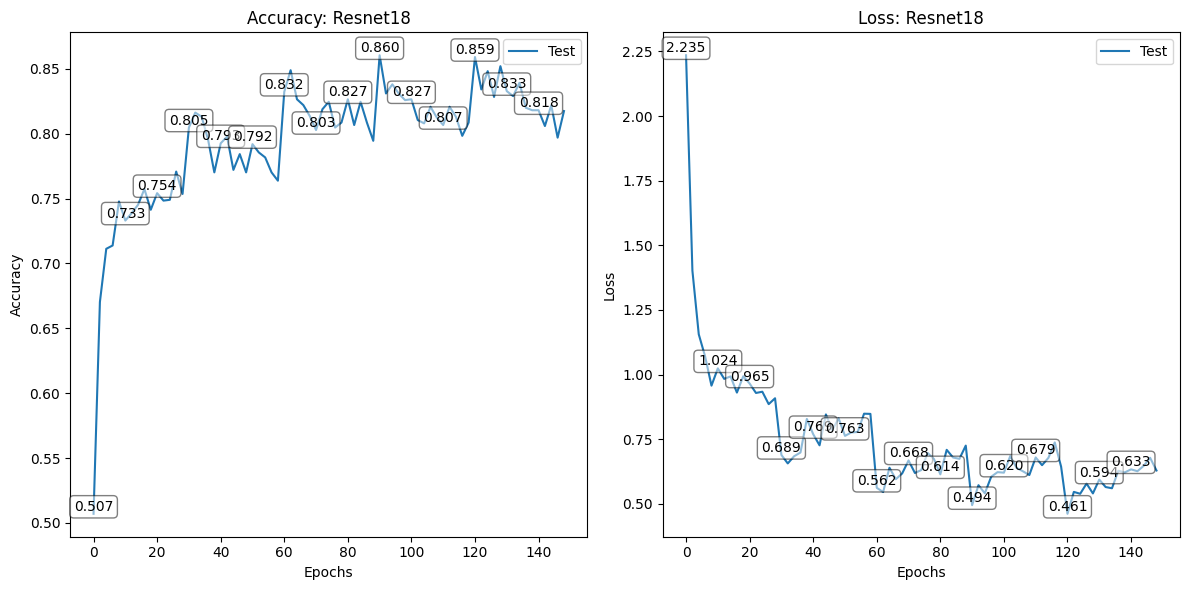

In [69]:
draw(acc_test_history,loss_test_history,model)

### Alexnet

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
TRAIN_RATIO = 0.9
batch_size = 64
size = (224, 224)
train_loader, test_loader = getDataLoader(caltech101_path, size, mean, std, TRAIN_RATIO, batch_size)
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
# Fixer les paramètres pré-entraînés (ils ne seront pas optimisés)
for param in model.parameters():
    param.requires_grad = False
# Modifier la dernière couche entièrement connectée pour le nombre de classes correct
num_classes = 101
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.name = "Alexnet"
model = model.to(device)
# Définir un optimiseur ne modifiant que les paramètres nouvellement ajoutés
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30

acc_test_history_2,loss_test_history_2 = launchModelKCross(model,train_loader,test_loader,num_epochs,criterion,optimizer)

Classes: 101
Nombre total d'images: 8677
batch train: 123  batch test: 14
Fold [1/5]
Epoch [1/30] - Accuracy: 0.6588, Loss: 1.3896
Epoch [3/30] - Accuracy: 0.6729, Loss: 1.3258
Epoch [5/30] - Accuracy: 0.6684, Loss: 1.3149
Epoch [7/30] - Accuracy: 0.6773, Loss: 1.3166
Epoch [9/30] - Accuracy: 0.6869, Loss: 1.3415
Epoch [11/30] - Accuracy: 0.6754, Loss: 1.3531
Epoch [13/30] - Accuracy: 0.6876, Loss: 1.3271
Epoch [15/30] - Accuracy: 0.6857, Loss: 1.4450
Epoch [17/30] - Accuracy: 0.6825, Loss: 1.4433
Epoch [19/30] - Accuracy: 0.6895, Loss: 1.4288
Epoch [21/30] - Accuracy: 0.6985, Loss: 1.4898
Epoch [23/30] - Accuracy: 0.6901, Loss: 1.5345
Epoch [25/30] - Accuracy: 0.6959, Loss: 1.5288
Epoch [27/30] - Accuracy: 0.6985, Loss: 1.5029
Epoch [29/30] - Accuracy: 0.6882, Loss: 1.5801
Fold [1] - Mean Accuracy: 0.6837
Fold [2/5]
Epoch [1/30] - Accuracy: 0.8528, Loss: 0.5648
Epoch [3/30] - Accuracy: 0.8252, Loss: 0.6292
Epoch [5/30] - Accuracy: 0.8335, Loss: 0.6586
Epoch [7/30] - Accuracy: 0.8182, 

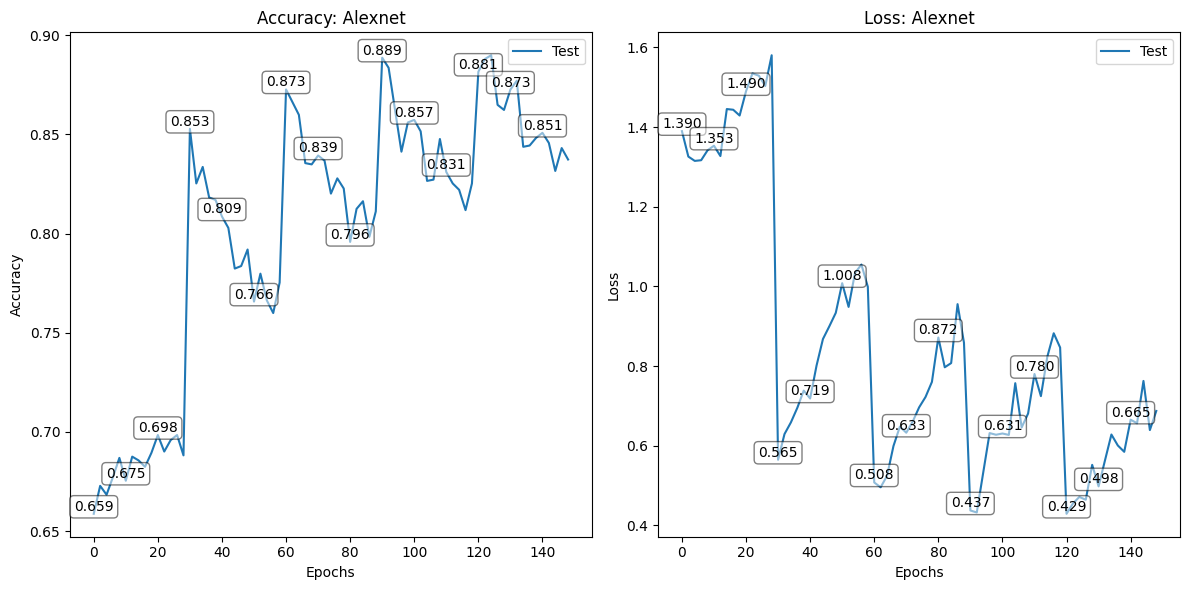

In [17]:
draw(acc_test_history_2,loss_test_history_2,model)

### squeezenet1_0

In [74]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
TRAIN_RATIO = 0.9
batch_size = 64
size = (224, 224)
train_loader, test_loader = getDataLoader(caltech101_path, size, mean, std, TRAIN_RATIO, batch_size)
model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
# Fixer les paramètres pré-entraînés (ils ne seront pas optimisés)
for param in model.parameters():
    param.requires_grad = False

# Modifier la dernière couche entièrement connectée pour le nombre de classes correct
num_classes = 101
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_classes
model.name = "Squeeznet1_0"
model = model.to(device)

# Définir un optimiseur ne modifiant que les paramètres nouvellement ajoutés
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30

acc_test_history_3,loss_test_history_3 = launchModelKCross(model,train_loader,test_loader,num_epochs,criterion,optimizer)

Classes: 101
Nombre total d'images: 8677
batch train: 123  batch test: 14


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 41.0MB/s]


Fold [1/5]
Epoch [1/30] - Accuracy: 0.5743, Loss: 1.8520
Epoch [3/30] - Accuracy: 0.6722, Loss: 1.2418
Epoch [5/30] - Accuracy: 0.7100, Loss: 1.1533
Epoch [7/30] - Accuracy: 0.7081, Loss: 1.1351
Epoch [9/30] - Accuracy: 0.7164, Loss: 1.0892
Epoch [11/30] - Accuracy: 0.7266, Loss: 1.0774
Epoch [13/30] - Accuracy: 0.7298, Loss: 1.0720
Epoch [15/30] - Accuracy: 0.7330, Loss: 1.0761
Epoch [17/30] - Accuracy: 0.7465, Loss: 1.0516
Epoch [19/30] - Accuracy: 0.7305, Loss: 1.0901
Epoch [21/30] - Accuracy: 0.7350, Loss: 1.0241
Epoch [23/30] - Accuracy: 0.7311, Loss: 1.0226
Epoch [25/30] - Accuracy: 0.7375, Loss: 1.0903
Epoch [27/30] - Accuracy: 0.7407, Loss: 1.0694
Epoch [29/30] - Accuracy: 0.7414, Loss: 1.0535
Fold [1] - Mean Accuracy: 0.7155
Fold [2/5]
Epoch [1/30] - Accuracy: 0.8387, Loss: 0.5481
Epoch [3/30] - Accuracy: 0.8412, Loss: 0.5824
Epoch [5/30] - Accuracy: 0.8393, Loss: 0.5927
Epoch [7/30] - Accuracy: 0.8143, Loss: 0.6213
Epoch [9/30] - Accuracy: 0.8118, Loss: 0.7172
Epoch [11/30] -

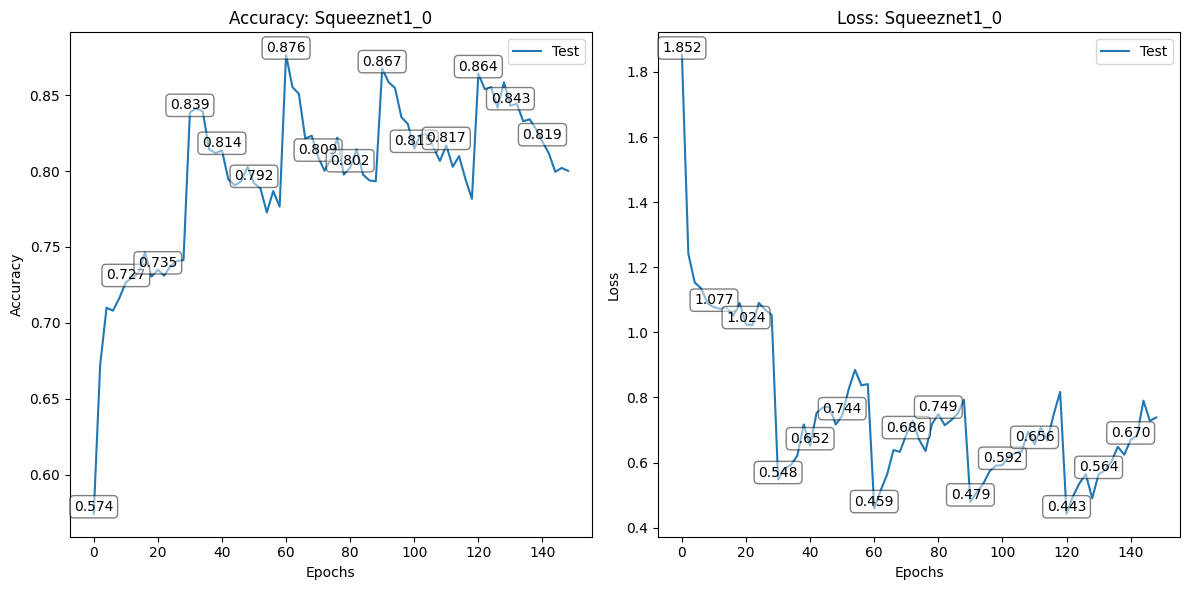

In [75]:
draw(acc_test_history_3,loss_test_history_3,model)

### vgg16

In [76]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
TRAIN_RATIO = 0.9
batch_size = 64
size = (224, 224)
train_loader, test_loader = getDataLoader(caltech101_path, size, mean, std, TRAIN_RATIO, batch_size)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
# Fixer les paramètres pré-entraînés (ils ne seront pas optimisés)
for param in model.parameters():
    param.requires_grad = False

# Modifier la dernière couche entièrement connectée pour le nombre de classes correct
num_classes = 101
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.name = "vgg16"
model = model.to(device)

# Définir un optimiseur ne modifiant que les paramètres nouvellement ajoutés
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30

acc_test_history_4,loss_test_history_4 = launchModelKCross(model,train_loader,test_loader,num_epochs,criterion,optimizer)

Classes: 101
Nombre total d'images: 8677
batch train: 123  batch test: 14


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 280MB/s]  


Fold [1/5]
Epoch [1/30] - Accuracy: 0.6722, Loss: 1.2796
Epoch [3/30] - Accuracy: 0.7010, Loss: 1.1446
Epoch [5/30] - Accuracy: 0.7196, Loss: 1.0724
Epoch [7/30] - Accuracy: 0.7055, Loss: 1.1139
Epoch [9/30] - Accuracy: 0.7183, Loss: 1.0569
Epoch [11/30] - Accuracy: 0.7324, Loss: 1.0562
Epoch [13/30] - Accuracy: 0.7356, Loss: 1.0260
Epoch [15/30] - Accuracy: 0.7414, Loss: 1.0520
Epoch [17/30] - Accuracy: 0.7375, Loss: 1.0225
Epoch [19/30] - Accuracy: 0.7388, Loss: 1.0523
Epoch [21/30] - Accuracy: 0.7490, Loss: 1.0339
Epoch [23/30] - Accuracy: 0.7260, Loss: 1.0704
Epoch [25/30] - Accuracy: 0.7439, Loss: 1.0330
Epoch [27/30] - Accuracy: 0.7369, Loss: 1.0427
Epoch [29/30] - Accuracy: 0.7542, Loss: 0.9770
Fold [1] - Mean Accuracy: 0.7275
Fold [2/5]
Epoch [1/30] - Accuracy: 0.8131, Loss: 0.6554
Epoch [3/30] - Accuracy: 0.7919, Loss: 0.7128
Epoch [5/30] - Accuracy: 0.7907, Loss: 0.7412
Epoch [7/30] - Accuracy: 0.7919, Loss: 0.7630
Epoch [9/30] - Accuracy: 0.7862, Loss: 0.7343
Epoch [11/30] -

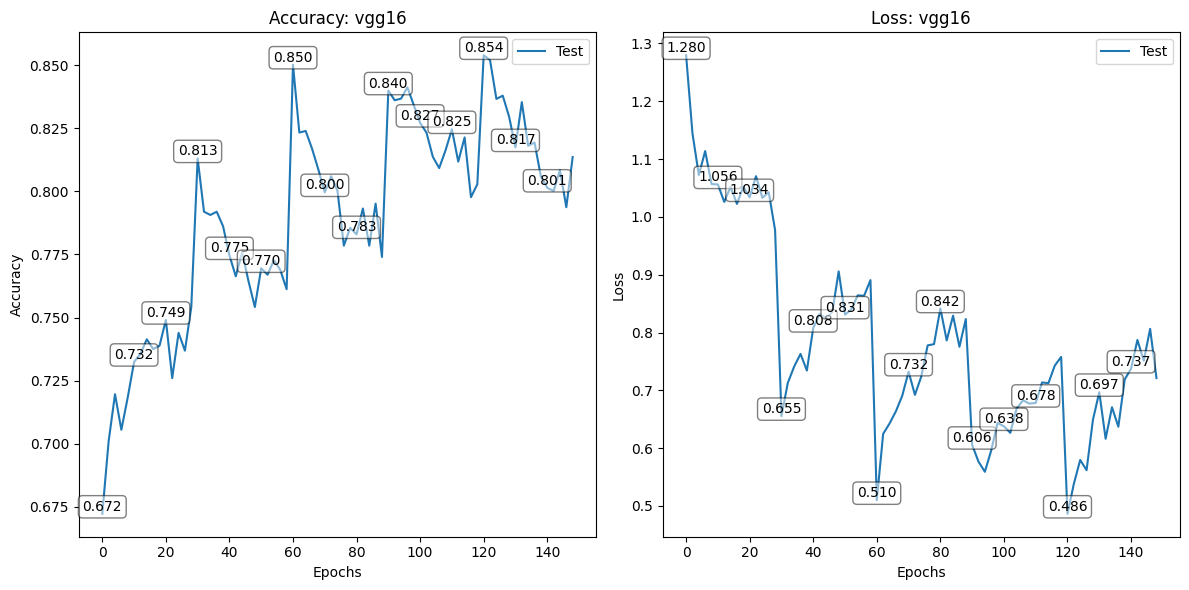

In [77]:
draw(acc_test_history_4,loss_test_history_4,model)

### densenet161

In [78]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
TRAIN_RATIO = 0.9
batch_size = 64
size = (224, 224)
train_loader, test_loader = getDataLoader(caltech101_path, size, mean, std, TRAIN_RATIO, batch_size)
model = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
# Fixer les paramètres pré-entraînés (ils ne seront pas optimisés)
for param in model.parameters():
    param.requires_grad = False

# Modifier la dernière couche entièrement connectée pour le nombre de classes correct
num_classes = 101
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.name = "densenet161"
model = model.to(device)

# Définir un optimiseur ne modifiant que les paramètres nouvellement ajoutés
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30

acc_test_history_5,loss_test_history_5 = launchModelKCross(model,train_loader,test_loader,num_epochs,criterion,optimizer)

Classes: 101
Nombre total d'images: 8677
batch train: 123  batch test: 14


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 252MB/s]  


Fold [1/5]
Epoch [1/30] - Accuracy: 0.6178, Loss: 1.8073
Epoch [3/30] - Accuracy: 0.7471, Loss: 1.0777
Epoch [5/30] - Accuracy: 0.7907, Loss: 0.8209
Epoch [7/30] - Accuracy: 0.7990, Loss: 0.7839
Epoch [9/30] - Accuracy: 0.7817, Loss: 0.8055
Epoch [11/30] - Accuracy: 0.7958, Loss: 0.7480
Epoch [13/30] - Accuracy: 0.8035, Loss: 0.7048
Epoch [15/30] - Accuracy: 0.8163, Loss: 0.6813
Epoch [17/30] - Accuracy: 0.8182, Loss: 0.6863
Epoch [19/30] - Accuracy: 0.8124, Loss: 0.6739
Epoch [21/30] - Accuracy: 0.8111, Loss: 0.6927
Epoch [23/30] - Accuracy: 0.8003, Loss: 0.7066
Epoch [25/30] - Accuracy: 0.8118, Loss: 0.6704
Epoch [27/30] - Accuracy: 0.8163, Loss: 0.6563
Epoch [29/30] - Accuracy: 0.8079, Loss: 0.6935
Fold [1] - Mean Accuracy: 0.7886
Fold [2/5]
Epoch [1/30] - Accuracy: 0.8976, Loss: 0.3797
Epoch [3/30] - Accuracy: 0.8841, Loss: 0.4156
Epoch [5/30] - Accuracy: 0.8828, Loss: 0.3974
Epoch [7/30] - Accuracy: 0.8649, Loss: 0.4459
Epoch [9/30] - Accuracy: 0.8764, Loss: 0.4574
Epoch [11/30] -

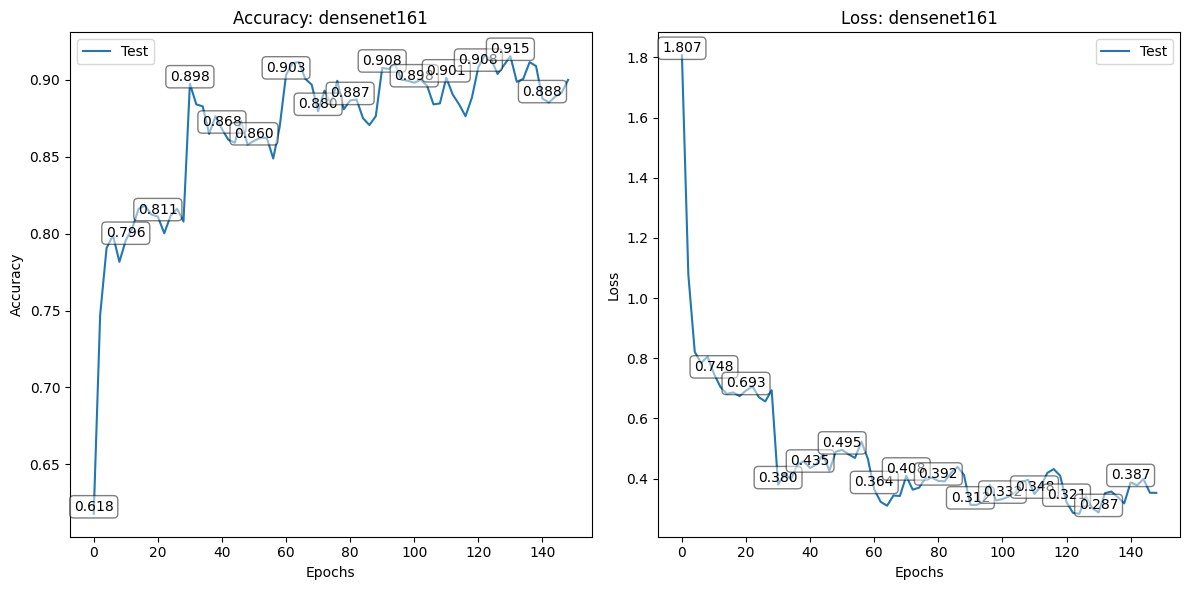

In [79]:
draw(acc_test_history_5,loss_test_history_5,model)

### inception_v3

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
TRAIN_RATIO = 0.9
batch_size = 64
size = (299, 299)
train_loader, test_loader = getDataLoader(caltech101_path, size, mean, std, TRAIN_RATIO, batch_size)
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
# Fixer les paramètres pré-entraînés (ils ne seront pas optimisés)
for param in model.parameters():
    param.requires_grad = False

# Modifier la dernière couche entièrement connectée pour le nombre de classes correct
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.name = "inception_v3"
model = model.to(device)

# Définir un optimiseur ne modifiant que les paramètres nouvellement ajoutés
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30

acc_test_history_6,loss_test_history_6 = launchModelKCross(model,train_loader,test_loader,num_epochs,criterion,optimizer)

Classes: 101
Nombre total d'images: 8677
batch train: 123  batch test: 14


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 96.5MB/s] 


Fold [1/5]
Epoch [1/30] - Accuracy: 0.6293, Loss: 1.9588
Epoch [3/30] - Accuracy: 0.7311, Loss: 1.1226
Epoch [5/30] - Accuracy: 0.7382, Loss: 1.0008
Epoch [7/30] - Accuracy: 0.7593, Loss: 0.9246
Epoch [9/30] - Accuracy: 0.7574, Loss: 0.9038
Epoch [11/30] - Accuracy: 0.7714, Loss: 0.8932
Epoch [13/30] - Accuracy: 0.7817, Loss: 0.8203
Epoch [15/30] - Accuracy: 0.7695, Loss: 0.8446
Epoch [17/30] - Accuracy: 0.7785, Loss: 0.8527
Epoch [19/30] - Accuracy: 0.7804, Loss: 0.8071
Epoch [21/30] - Accuracy: 0.7753, Loss: 0.7918
Epoch [23/30] - Accuracy: 0.7778, Loss: 0.7850
Epoch [25/30] - Accuracy: 0.7778, Loss: 0.8183
Epoch [27/30] - Accuracy: 0.7708, Loss: 0.8166
Epoch [29/30] - Accuracy: 0.7638, Loss: 0.8656
Fold [1] - Mean Accuracy: 0.7575
Fold [2/5]
Epoch [1/30] - Accuracy: 0.8438, Loss: 0.5473
Epoch [3/30] - Accuracy: 0.8348, Loss: 0.5538
Epoch [5/30] - Accuracy: 0.8201, Loss: 0.6430
Epoch [7/30] - Accuracy: 0.8342, Loss: 0.6264
Epoch [9/30] - Accuracy: 0.8131, Loss: 0.6847
Epoch [11/30] -

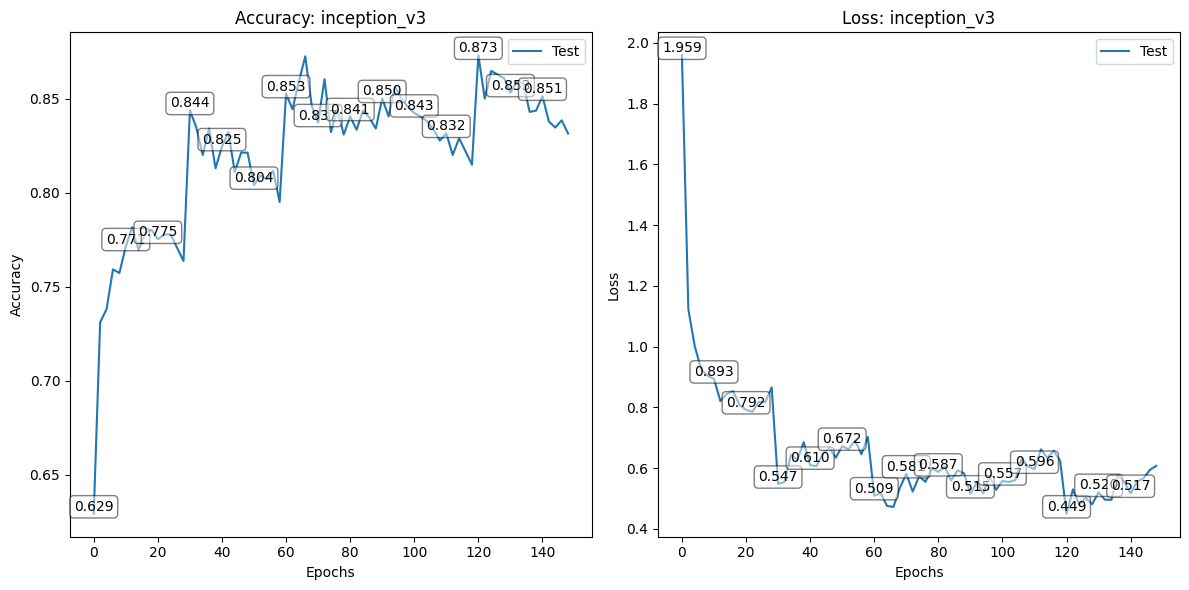

In [7]:
draw(acc_test_history_6,loss_test_history_6,model)

## Résultats

Les expérimentations montrent que pour 5 folds et 30 epochs, le modèle le plus performant est DenseNet-161 avec une accuracy moyenne de 0.9028 et un maximum de 0.9161. Les autres modèles ont une accuracy moyenne comprise entre 0.82 et 0.86. Un second modèle performant est AlexNet qui a obtenu une accuracy de 0.8898 durant le dernier fold.